# Seminario 
## Inferencia de Redes

Parte práctica Aracne en R.

A partir de datos obtenidos de GeneNetWeaver (50 genes y 2100 muestras de levadura) vamos a inferir una red de co-expresión que compararemos con su red real.

#### Se cargan librerías

In [1]:
#Cargo las librerías necesarias

library(infotheo)

In [2]:
#Cargo las librerías necesarias

library(minet)

In [3]:
#Cargo las librerías necesarias

library(igraph)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



### Cargar datos
Lo primero es **cargar datos**, en este caso, la tabla con todos los datos de niveles de expresión de los 50 genes.

In [4]:
#Cargo datos (50 genes y 2100 muestras)

matriz <- read.table("datos_tchan/50_yeast3_large.txt", header = FALSE, row.names = 1)

colnames(matriz) <- paste0("S", 1:length(colnames(matriz)))

In [5]:
#Conversión


matriz <- as.matrix(matriz)

In [6]:
head(matriz)

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,⋯,S2091,S2092,S2093,S2094,S2095,S2096,S2097,S2098,S2099,S2100
G1,0.5904386,0.6494695,0.6415226,0.6466765,0.6787227,0.7076366,0.5728600,0.6668172,0.5930201,0.6369869,⋯,0.7170053,0.6903840,0.5856704,0.7309970,0.7554710,0.6419026,0.6851225,0.5357749,0.6698642,0.6252516
G2,0.6607207,0.5792471,0.5067030,0.6401290,0.5568823,0.6177573,0.5193320,0.6597800,0.5811059,0.5861751,⋯,0.6411482,0.5167690,0.6162134,0.5653422,0.5987979,0.6996318,0.5513086,0.6452883,0.5195914,0.5898541
G3,0.0238079,0.0661596,0.0198063,0.0274858,0.0396209,0.0228682,0.0405068,0.0313639,0.0417402,0.0536814,⋯,0.0180118,0.0306865,0.0268400,0.0339213,0.0187694,0.0172142,0.0499985,0.0207562,0.0637935,0.0143334
G4,0.4103435,0.4578283,0.5039480,0.4059277,0.3395978,0.4005979,0.3420005,0.3630926,0.4502178,0.3680989,⋯,0.4102315,0.4778529,0.3386120,0.3873853,0.4201280,0.4754042,0.3424239,0.3684934,0.4815954,0.4152373
G5,0.0186839,0.0162421,0.0133235,0.0188958,0.0078155,0.0375791,0.0157540,0.0355669,0.0250468,0.0120721,⋯,0.0444553,0.0232748,0.0139499,0.0326022,0.0076778,0.0210129,0.0561467,0.0367210,0.0193982,0.0471455
G6,0.5381079,0.4771453,0.6052786,0.5674216,0.5476221,0.5450695,0.5758959,0.5264122,0.5197751,0.5566205,⋯,0.5385942,0.6033141,0.5423463,0.4750334,0.6284975,0.5447243,0.5828140,0.5164865,0.5385528,0.4684451


Ahora crearemos una matriz vacía con dimensión 50x50 (correspondiente al número de genes) para posteriormente guardar los valores de MI para cada par de genes.

In [7]:
#Se crea matriz vacía para MI

matriz_MI <- matrix(nrow = 50, ncol = 50)
colnames(matriz_MI) <- rownames(matriz)
rownames(matriz_MI) <- rownames(matriz)

### Estimación de MI
Función para estimar los valores de MI entre cada par de genes.

Notemos que primero tomamos el renglón correspondientes a cada gen por analizar y se ***discretiza***.

In [8]:
#Se calcula MI

for(i in 1:50){
  for(j in 1:50){
      
    var.a <- matriz[i,]
    var.b <- matriz[j,]
    
    var.a <- discretize(var.a, disc = "equalwidth") #Discretización de la v.a. g1
    var.b <- discretize(var.b, disc = "equalwidth") #Discretización de la v.a. g2
    
    mutual_info <- mutinformation(X = var.a, Y = var.b, method = "shrink")
    
    matriz_MI[i,j] <- mutual_info
  }
}

In [9]:
#Se elimina la diagonal

diag(matriz_MI) <- 0

Graficamos la red que obtenemos.

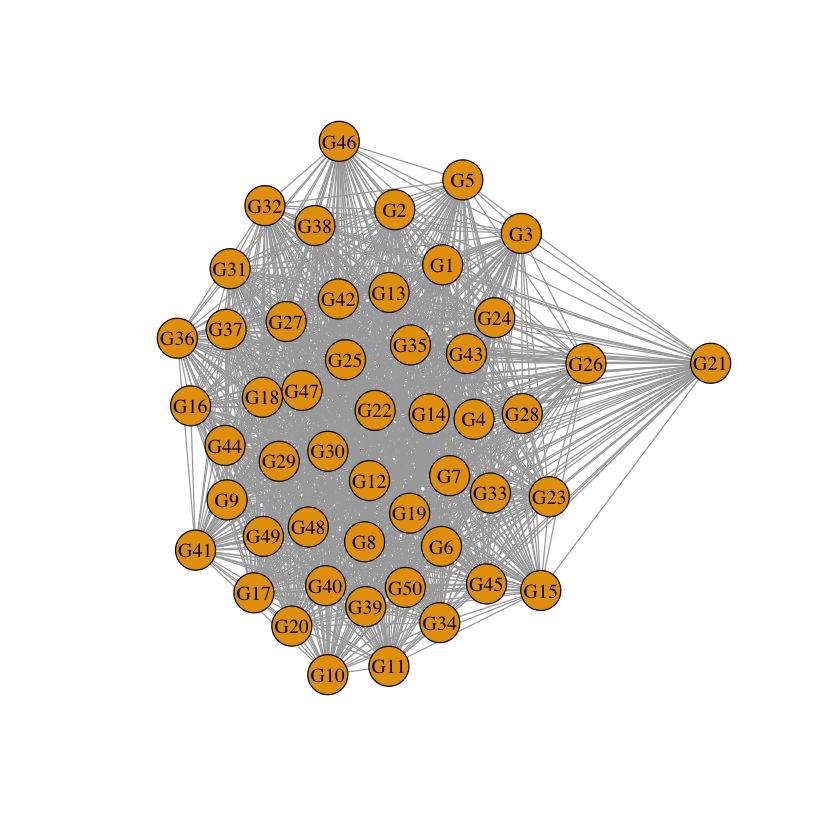

In [10]:
#Veamos la red

g0 <- graph_from_adjacency_matrix(matriz_MI, mode = "undirected", weighted = TRUE)
plot(g0)

### Filtro: Umbral

Calculamos el umbral estadístico con el cual haremos el primer filtro.

In [11]:
#Filtro 1. Cálculo del umbral estadístico (15%)

mi_0 <- quantile(matriz_MI, 0.85)
mi_0

85% 
0.04990777

In [12]:
#Se guarda la matriz original de MI

matriz_MI0 <- matriz_MI

**Filtramos** "Eliminaremos" todas las entradas de la matriz_MI cuyos valores sean menores al umbral establecido.

In [13]:
# Filtro 1. Se eliminan entradas por debajo del umbral.

for(i in 1:50){
  for (j in 1:50) {
      
    if(matriz_MI[i, j] < mi_0){
      matriz_MI[i, j] = 0
    } else{
      matriz_MI[i, j] = matriz_MI[i, j]
    }
  }
}

¿Quitamos enlaces?

In [14]:
#Comparación

table(matriz_MI0 == matriz_MI)


FALSE  TRUE 
 2075   425 

Graficamos la red después del primer filtro.

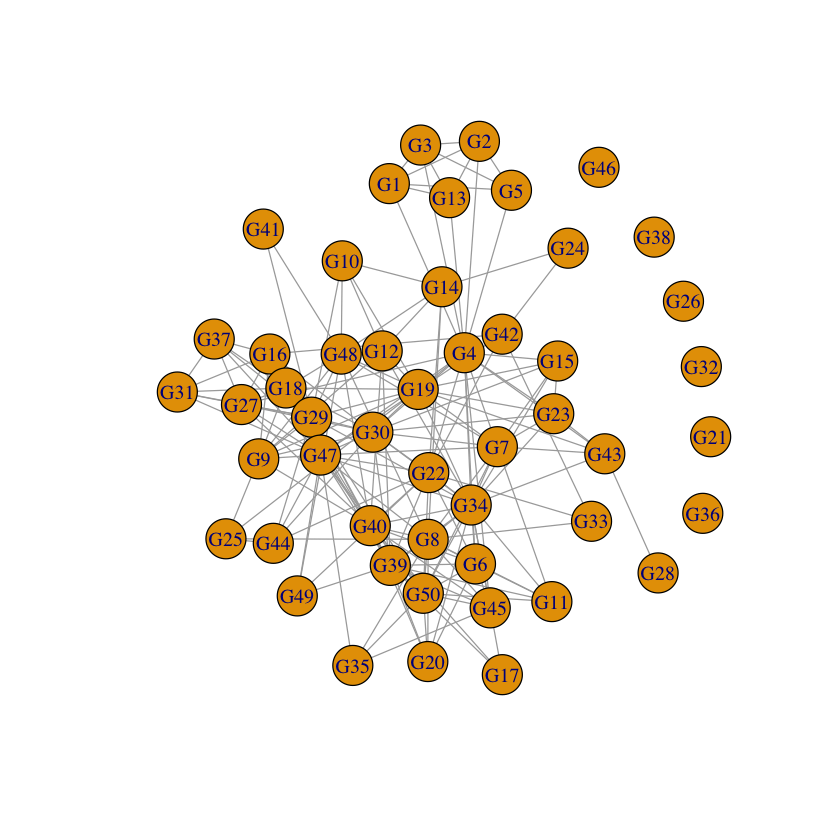

In [15]:
#Veamos la red

g1 <- graph_from_adjacency_matrix(matriz_MI, mode = "undirected", weighted = TRUE)
plot(g1)

## Hasta aquí hemos inferido una red con Relevance Networks.

### Filtro: DPI

De tripletes de genes conectados (triángulos) se busca el enlace con menos MI y si éste es además menor que un umbral establecido, se elimina.

Aquí usamos la función ***aracne*** de la librería *minet*, la cual hace **DPI**.

In [16]:
#Filtro 2. DPI (aracne)

inf_net <- aracne(matriz_MI, eps = 0.05)

Finalmente, graficamos la red inferida tras DPI.

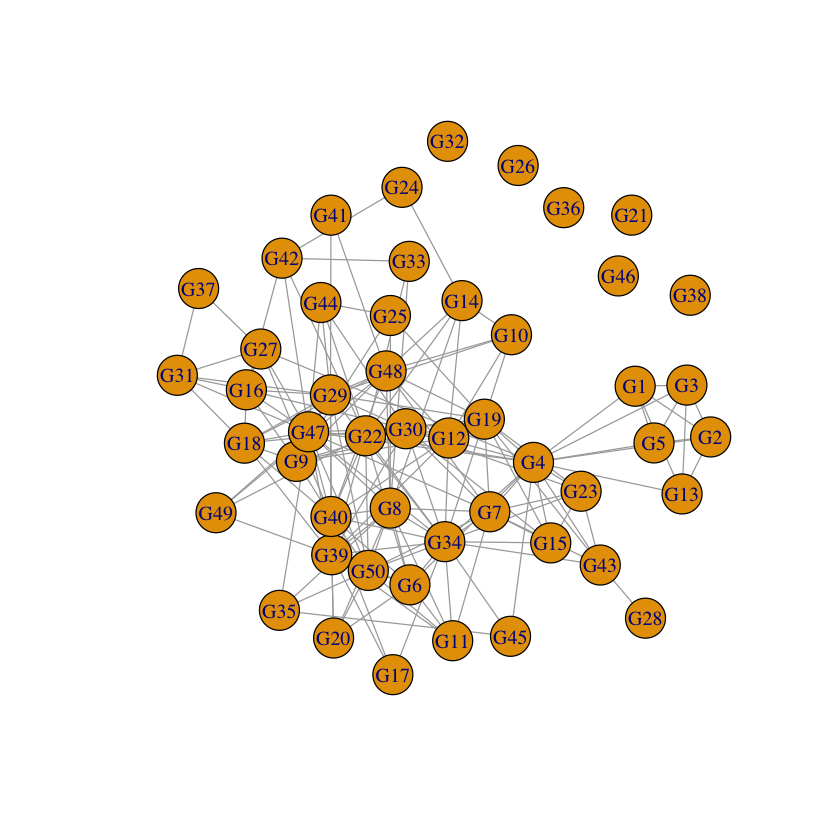

In [17]:
#Graficamos

g_inf <- graph_from_adjacency_matrix(inf_net, mode = "undirected", weighted = TRUE)
plot(g_inf)

### Ahora sí, ya podemos decir: 

 
 
## ¡Hemos inferido una red por medio del algoritmo 
# ARACNE!  =)

#### Ahora vamos a comparar con la red real.
 
Primero cargamos los datos.

In [18]:
#Cargo datos de la red real

matriz_real <- read.table("datos_tchan/50_yeast3.tsv", header = FALSE)

In [19]:
matriz_real

V1,V2,V3
G1,G2,1
G3,G1,1
G4,G1,1
G4,G3,1
G4,G5,1
G4,G6,1
G4,G7,1
G4,G8,1
G4,G9,1
G4,G12,1


Graficamos la red.

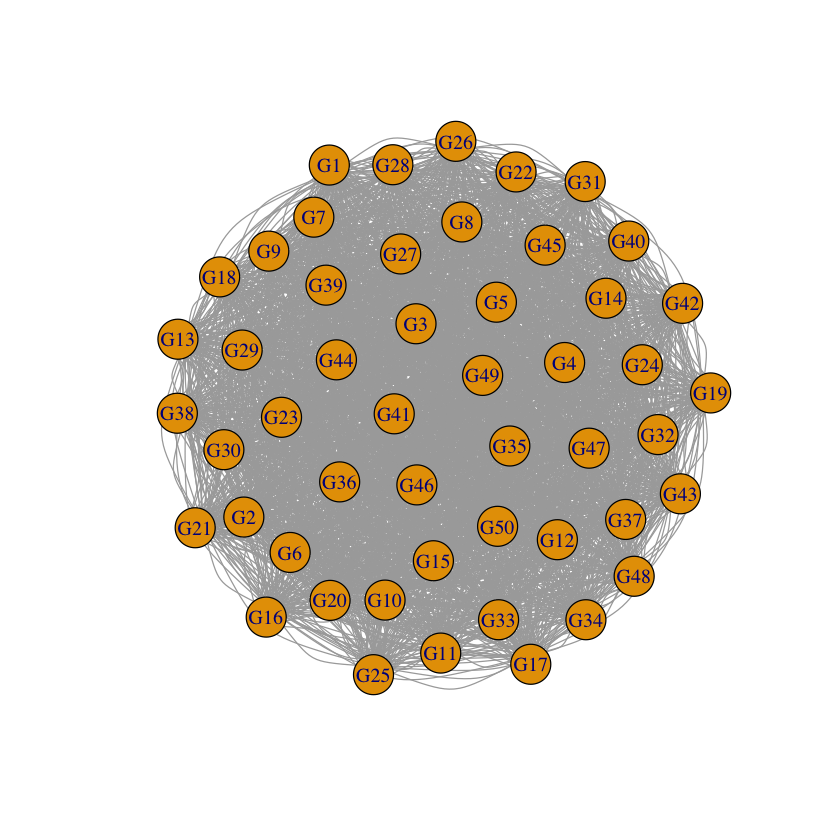

In [20]:
#Graficamos la red real 

g_real <- graph_from_data_frame(matriz_real, directed = FALSE)
plot(g_real)

Eliminamos los enlaces con MI = 0, pues los dibujó.

In [21]:
#Se eliminan los enlaces con MI = 0

g_real <- delete_edges(g_real, E(g_real)[V3 == 0])

#### Graficamos la red real

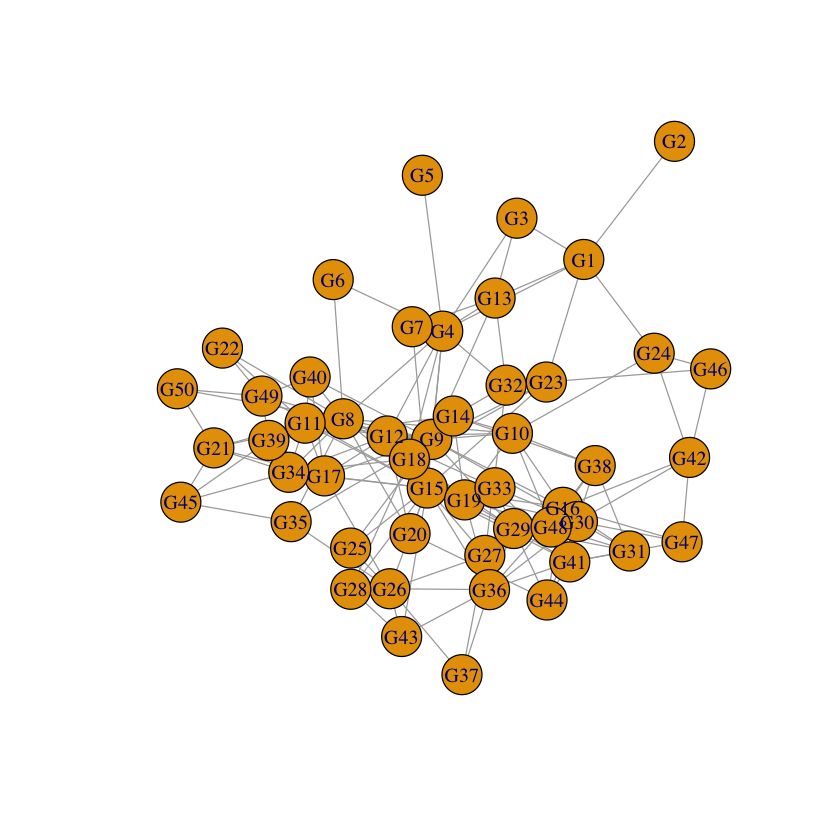

In [22]:
#Se grafica g_real

plot(g_real)

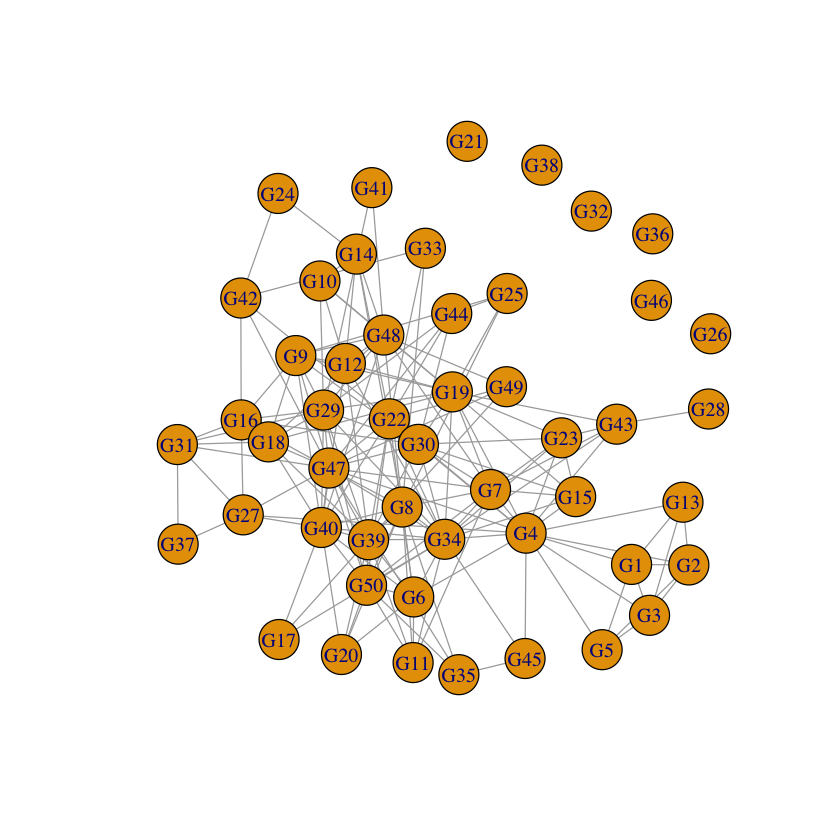

In [23]:
#Gráfica de la red inferida
plot(g_inf)

Haremos algunas *comparaciones*.

In [24]:
#Se obtienen las matrices de adyacencia de ambas redes

real.matrix <- get.adjacency(g_real)
g_inf.matrix <- get.adjacency(g_inf)

In [25]:
#Chequemos si son iguales

table(as.matrix(real.matrix == g_inf.matrix))


FALSE  TRUE 
  578  1922 

Más *comparaciones*.

In [26]:
#Verdaderos positivos

length(which(as.matrix(real.matrix) == 1 & as.matrix(g_inf.matrix) == 1))

[1] 58

In [27]:
#Falsos negativos

length(which(as.matrix(real.matrix) == 1 & as.matrix(g_inf.matrix) == 0))

[1] 288

In [28]:
#Falsos positivos

length(which(as.matrix(real.matrix) == 0 & as.matrix(g_inf.matrix) == 1))

[1] 290

In [29]:
#Verdaderos negativos

length(which(as.matrix(real.matrix) == 0 & as.matrix(g_inf.matrix) == 0))

[1] 1864